In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
import numpy as np

In [5]:
sns.set_theme(style="whitegrid")
sns.set_context('paper')

pd.set_option('display.max_rows', 10)

In [9]:
data_col = 'total_energy'
# temperature = 45

In [26]:
data_col = 'pkg_energy'
temperatures = [65, 45]


hist_df = pd.DataFrame()

for temperature in temperatures:
    df1 = pd.read_csv(f'../data/results_{temperature}_1.csv')
    df2 = pd.read_csv(f'../data/results_{temperature}_2.csv')
    
    df1['total_energy'] = df1['pkg_energy'] + df1['dram_energy']
    df2['total_energy'] = df2['pkg_energy'] + df2['dram_energy']

    df1['power_dissipation'] = df1['total_energy'] / df1['execution_time']
    df2['power_dissipation'] = df2['total_energy'] / df2['execution_time']
    
    progs = df1['program'].unique()
    flags = df1['flag'].unique()
    
    increase_df = calculate_increase(df1, df2, data_col)
    increase_df['Temperature'] = [temperature] * len(increase_df) 
    
    hist_df = hist_df.append(increase_df)

/tmp/ipykernel_2348165/790618140.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hist_df = hist_df.append(increase_df)
/tmp/ipykernel_2348165/790618140.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hist_df = hist_df.append(increase_df)


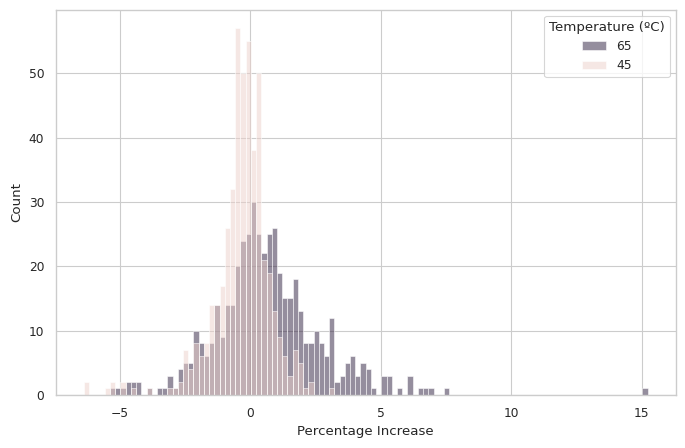

In [28]:
plt.figure(figsize=(8,5))

hist = sns.histplot(hist_df, x='increase', hue='Temperature', binwidth=0.2)
plt.xlabel('Percentage Increase')

plt.legend(title='Temperature (ºC)', labels=temperatures)

plt.show()

In [140]:
df1 = pd.read_csv(f'../data/results_{temperature}_1.csv')
df2 = pd.read_csv(f'../data/results_{temperature}_2.csv')

df1['total_energy'] = df1['pkg_energy'] + df1['dram_energy']
df2['total_energy'] = df2['pkg_energy'] + df2['dram_energy']

df1['power_dissipation'] = df1['total_energy'] / df1['execution_time']
df2['power_dissipation'] = df2['total_energy'] / df2['execution_time']



progs = df1['program'].unique()
print(f"Programs ({len(progs)}): {progs}")
flags = df1['flag'].unique()
print(f"Flags ({len(flags)}): {flags}")

Programs (18): ['circsim' 'hash' 'bernouilli' 'integrate' 'coins' 'queens' 'anna' 'fluid'
 'binary-trees' 'pidigits' 'callback001' 'chan' 'power' 'treejoin'
 'fannkuch-redux' 'n-body' 'reverse-complement' 'spectral-norm']
Flags (27): ['-O2' '-fno-case-merge' '-fno-case-folding' '-fno-call-arity'
 '-fno-exitification' '-fno-cmm-elim-common-blocks' '-fno-cmm-sink'
 '-fno-block-layout-cfg' '-fno-cpr-anal' '-fno-cse' '-fno-stg-cse'
 '-fno-dmd-tx-dict-sel' '-fno-do-eta-reduction'
 '-fno-do-lambda-eta-expansion' '-fno-float-in' '-fno-full-laziness'
 '-fno-ignore-asserts' '-fno-loopification' '-fno-specialise'
 '-fno-solve-constant-dicts' '-fno-stg-lift-lams' '-fno-strictness'
 '-fno-unbox-small-strict-fields' '-fno-spec-constr' '-fno-liberate-case'
 '-funfolding-use-threshold=40' '-funfolding-use-threshold=160']


In [2]:
def calculate_increase(df1, df2, column):
    new_dataframe = []

    for flag in flags:
        for prog in progs:
            base_mean = df1[(df1['flag'] == flag) & (df1['program'] == prog)][column].mean()
            diff_mean = df2[(df2['flag'] == flag) & (df2['program'] == prog)][column].mean()
            
            increase = ((diff_mean - base_mean) / base_mean) * 100
            
            new_dataframe.append([prog, flag, base_mean, diff_mean, increase])

    return pd.DataFrame(new_dataframe, columns=['program', 'flag', 'base_mean', 'diff_mean', 'increase'])

In [142]:
increase_df = calculate_increase(data_col)
increase_df['sig'] = [False] * len(increase_df)

display(increase_df[increase_df.increase == increase_df.increase.max()])
display(increase_df[increase_df.increase == increase_df.increase.min()])

,program,flag,base_mean,diff_mean,increase,sig
443,chan,-fno-liberate-case,17449.9,18673.6,7.012648,False


,program,flag,base_mean,diff_mean,increase,sig
214,reverse-complement,-fno-dmd-tx-dict-sel,9561.05,8520.5,-10.883219,False


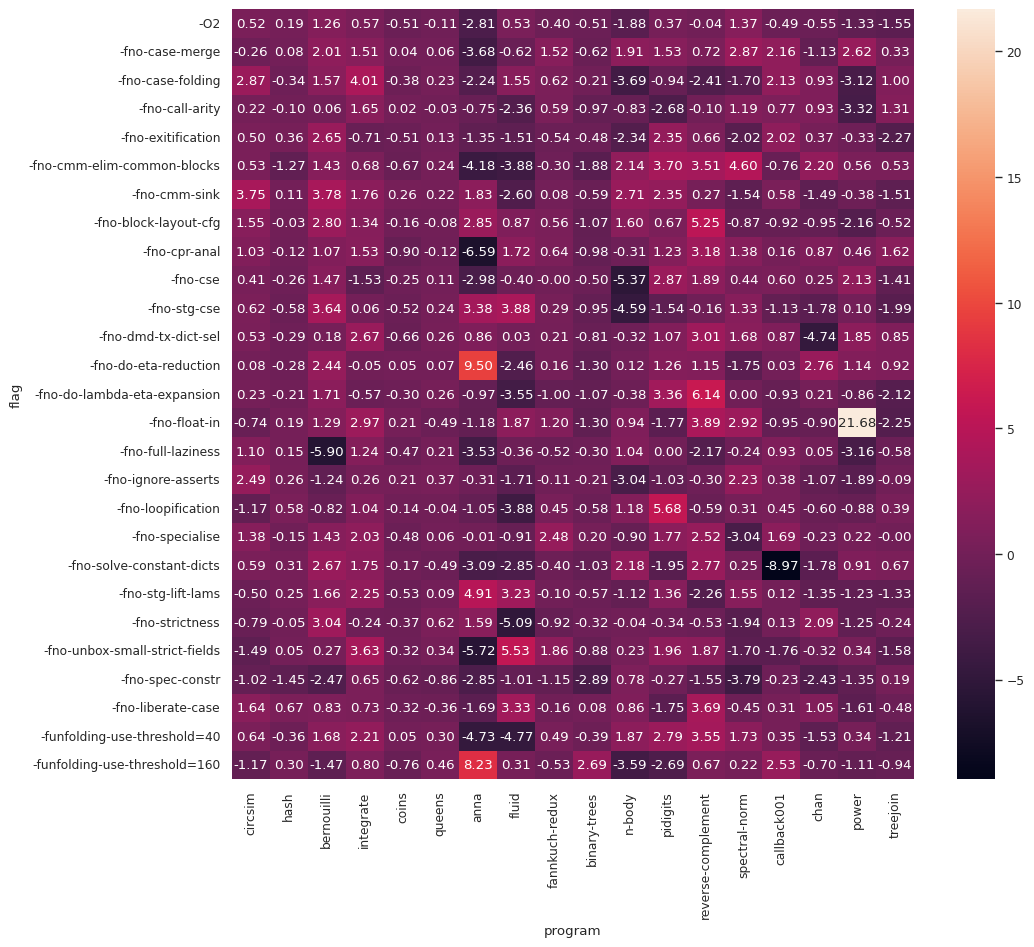

In [134]:
plt.figure(figsize=(11,10))
ax = sns.heatmap(
    data = increase_df.pivot_table(index='flag', columns='program', values='increase', sort=False),
    annot = increase_df.pivot_table(index='flag', columns='program', values='increase', sort=False),
    fmt='.2f'
)

plt.savefig(f"../charts/{data_col}_{temperature}_temperature_heat.pdf", bbox_inches='tight')
# plt.show()

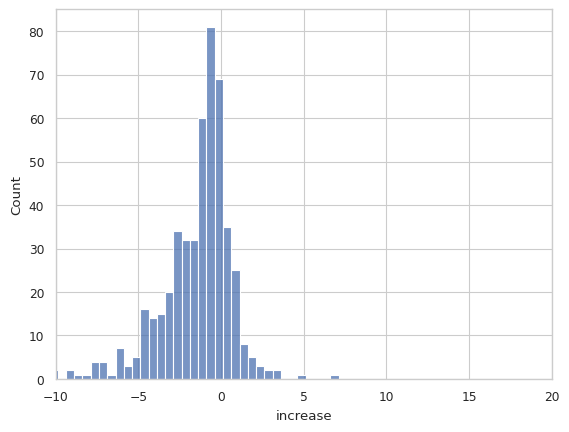

In [143]:
sns.histplot(increase_df, x='increase', binwidth=0.5)
plt.xlim(-10,20)

plt.show()

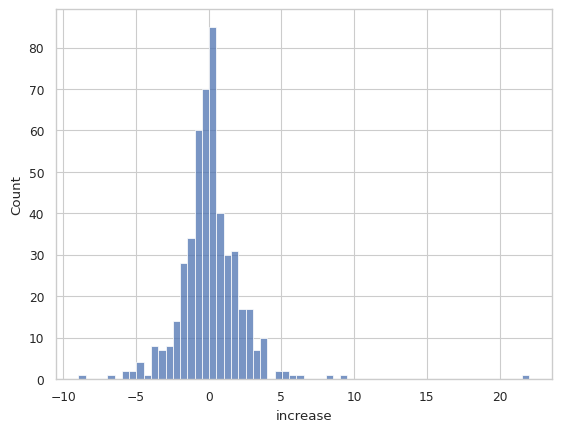

In [135]:
sns.histplot(increase_df, x='increase', binwidth=0.5)
# plt.xlim(-4,3)
plt.show()

In [37]:
from multiprocessing import Pool
from scipy.stats import ttest_ind
from utils import random_sampling, is_normal


task = [(prog, flag) for prog in progs for flag in flags]
# task = [('reverse-complement', '-fno-call-arity'), ('chan', '-O2')]
# task = [('fluid', '-fno-strictness')]

def is_significant(sample):
    prog, flag = sample
    
    fst_run_df = df1[(df1['flag'] == flag) & (df1['program'] == prog)]
    snd_run_df = df2[(df2['flag'] == flag) & (df2['program'] == prog)]
    
    fst_run_data = fst_run_df[data_col].values
    snd_run_data = snd_run_df[data_col].values
    
    if is_normal(fst_run_data) and is_normal(snd_run_data) and np.var(fst_run_data) != np.var(snd_run_data):
        _, p = ttest_ind(fst_run_data, snd_run_data, equal_var=False)
    else:
        p, _, _ = random_sampling(fst_run_df, snd_run_df, data_col, reps=100000)
        
    return prog, flag, p


with Pool() as pool:
    results = pool.map(is_significant, task)

    for prog, flag, pvalue in results:
        i = increase_df.index[(increase_df['program'] == prog) & (increase_df['flag'] == flag)].values[0]
        increase_df.at[i, 'sig'] = pvalue < 0.05

increase_df[increase_df['sig'] == True]

,program,flag,base_mean,diff_mean,increase,sig
1,hash,-O2,2481250.10,2451443.30,-1.201282,True
22,coins,-fno-case-merge,15125074.30,15066761.05,-0.385540,True
23,queens,-fno-case-merge,10888933.85,10839941.00,-0.449932,True
41,queens,-fno-case-folding,10914550.25,10839858.55,-0.684331,True
42,anna,-fno-case-folding,1131112.85,1150799.75,1.740489,True
...,...,...,...,...,...,...
380,bernouilli,-fno-strictness,844986.70,822739.85,-2.632805,True
396,circsim,-fno-unbox-small-strict-fields,1639168.05,1618810.10,-1.241968,True
414,circsim,-fno-spec-constr,1653932.65,1633476.35,-1.236828,True
435,integrate,-fno-liberate-case,772547.65,752854.60,-2.549105,True


In [19]:
sig_increase_df = increase_df[increase_df['sig'] == True]

display(sig_increase_df[sig_increase_df.increase == sig_increase_df.increase.max()])
display(sig_increase_df[sig_increase_df.increase == sig_increase_df.increase.min()])

,program,flag,base_mean,diff_mean,increase,sig
34,anna,-fno-case-folding,1088843.05,1107181.1,1.684178,True


,program,flag,base_mean,diff_mean,increase,sig
44,bernouilli,-fno-call-arity,750818.95,729612.45,-2.824449,True
